## Raden

This notebok explores a basic hierarchical Bayesian model. It is going to regress over the amount of radeon in different floors of buildings.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
import theano
import seaborn as sns

np.random.seed(1)
data = pd.read_csv('radon.csv')
data.head()

## Clean the data

The data seems to be devaoid of NaNs

In [6]:
data.isnull().any()

Unnamed: 0     False
idnum          False
state          False
state2         False
stfips         False
zip            False
region         False
typebldg       False
floor          False
room           False
basement       False
windoor        False
rep            False
stratum        False
wave           False
starttm        False
stoptm         False
startdt        False
stopdt         False
activity       False
pcterr         False
adjwt          False
dupflag        False
zipflag        False
cntyfips       False
county         False
fips           False
Uppm           False
county_code    False
log_radon      False
dtype: bool

## Data Correlations

It seems like region, activity, uppm, and pcterr especially carry some predictive power to log_radon.

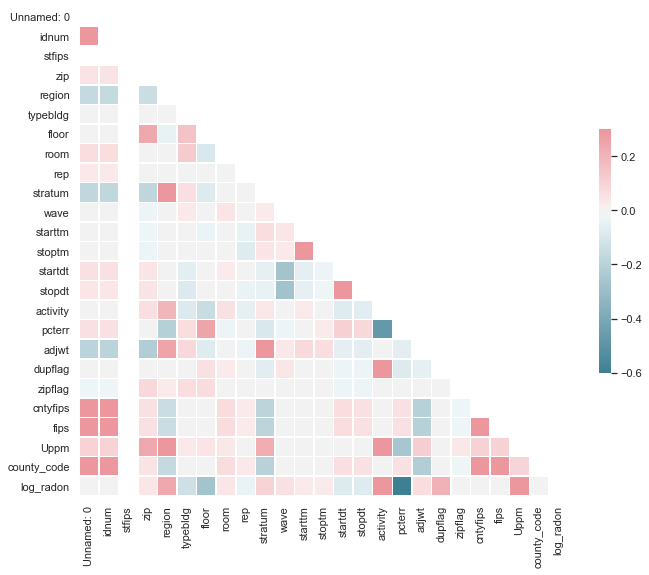

In [8]:
sns.set(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
features = ['region', 'activity', 'pcterr', 'Uppm']
target = 'log_radon'
grid = sns.PairGrid(data[features + [target]])
grid.map_upper(plt.scatter)
grid.map_lower(plt.scatter)
grid.map_diag(plt.hist)

In [12]:
data.Uppm.head()

0    0.502054
1    0.502054
2    0.502054
3    0.502054
4    0.428565
Name: Uppm, dtype: float64

### Model specification

There seems to be some patterns we can work with. The idea is to create a hierarchical model which predicts radon $y$ through

$y \sim \mathcal{N}(\mu, \sigma), \mu = \alpha + \beta^T X$

$\mu \sim \mathcal{N}(\mu_r, \sigma_r)$

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data[['activity', 'pcterr', 'Uppm', 'region']].values, 
    data[target].values, 
    test_size=.2
)

In [ ]:
import theano.tensor as T
X = theano.shared(X_train[:,:3])
y = theano.shared(y_train)
with pm.Model() as radon_model:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1, shape=(1, 3))
    mu = alpha + T.sum(X * beta, axis=1)
    sigma = pm.HalfNormal('sigma', 5)
    radon = pm.Normal('log_radon', mu=mu, sd=sigma, observed=y)
    trace = pm.sample(2000, tune=1000)
    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002091C3655F8>,
      dtype=object)

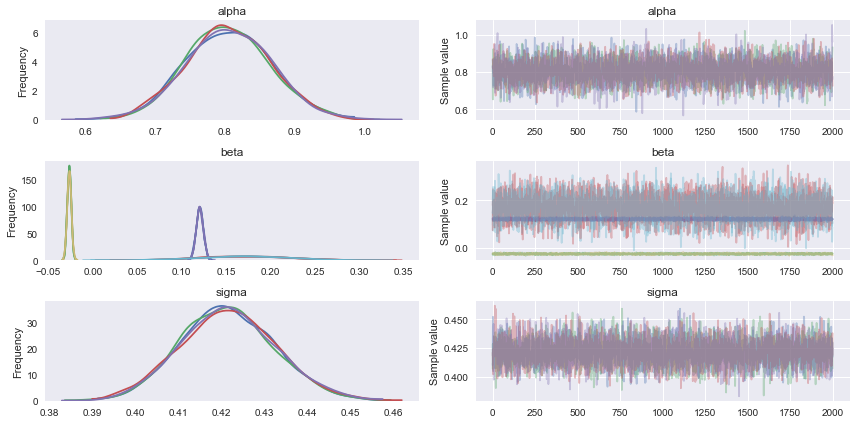

In [71]:
pm.traceplot(trace)

## In-sample accuracy

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.88it/s]
C:\Users\sebas\Anaconda3\envs\bayes\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


MAE: 0.2560998205693998


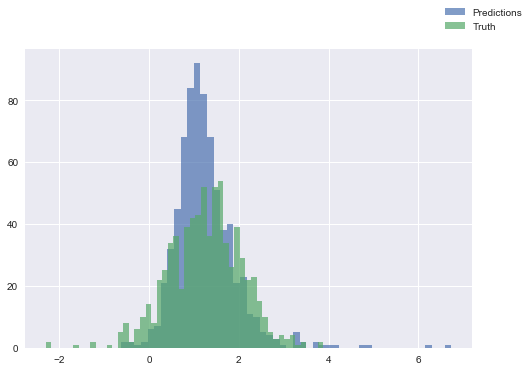

In [74]:
import matplotlib.pyplot as plt
X.set_value(X_train[:,:3])
y.set_value(y_train)

plt.style.use('seaborn')
n_samples = 1000
ppc = pm.sample_posterior_predictive(trace, samples=n_samples, model=radon_model)
predictions = ppc['log_radon'].mean(axis=0) 
fig, ax = plt.subplots(1, 1)
ax.hist(predictions, bins=50, label='Predictions', alpha=.7)
ax.hist(y_train, bins=50, label='Truth', alpha=.7)
fig.legend()
fig.show()

mae = np.abs(predictions - y_train).mean()
print(f'MAE: {mae}')

## Out-of-sample performance

In [76]:
X.set_value(X_test[:, :3])
y.set_value(y_test)

n_samples = 1000
ppc = pm.sample_posterior_predictive(trace, samples=n_samples, model=radon_model)
density = ppc['log_radon'].mean(axis=0) 
mae = np.abs(density - y_test).mean()
print(f'MAE: {mae}')

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.01it/s]


MAE: 0.2342501513351396


In [97]:
X_train[:, 3].astype(np.int) - 1

array([2, 2, 1, 1, 3, 4, 0, 2, 0, 4, 0, 1, 4, 2, 0, 2, 3, 3, 1, 1, 4, 4,
       4, 3, 1, 0, 2, 4, 0, 2, 3, 3, 0, 1, 4, 0, 2, 1, 3, 2, 2, 4, 2, 2,
       3, 0, 1, 2, 3, 0, 4, 2, 4, 0, 2, 3, 4, 1, 4, 4, 3, 0, 2, 2, 2, 2,
       1, 2, 1, 2, 2, 2, 0, 3, 1, 2, 4, 4, 4, 1, 1, 2, 2, 4, 2, 2, 4, 4,
       1, 3, 1, 0, 4, 0, 2, 1, 4, 2, 2, 4, 4, 2, 0, 0, 4, 2, 1, 4, 1, 1,
       4, 1, 3, 4, 4, 1, 3, 4, 3, 2, 3, 4, 0, 1, 3, 1, 2, 4, 2, 2, 2, 4,
       0, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 4, 2, 4, 2, 2, 1, 0, 2, 4, 2, 3,
       2, 2, 2, 1, 0, 4, 0, 1, 3, 3, 2, 2, 4, 1, 2, 4, 2, 2, 2, 1, 2, 1,
       4, 4, 4, 4, 4, 3, 2, 3, 3, 1, 2, 4, 3, 4, 0, 3, 2, 4, 4, 3, 4, 2,
       0, 3, 2, 4, 2, 2, 2, 2, 4, 0, 3, 1, 0, 3, 2, 1, 4, 2, 0, 0, 0, 2,
       1, 2, 2, 4, 1, 1, 2, 4, 4, 3, 0, 1, 4, 3, 3, 1, 2, 2, 3, 2, 4, 4,
       3, 2, 2, 0, 1, 0, 4, 1, 3, 1, 3, 1, 0, 3, 2, 0, 2, 4, 2, 4, 1, 3,
       2, 3, 4, 3, 1, 2, 0, 1, 3, 4, 0, 2, 3, 1, 0, 2, 2, 4, 1, 1, 0, 4,
       2, 2, 2, 3, 2, 3, 4, 2, 3, 2, 2, 2, 1, 2, 3,

## Hierarchical model

The model seem to perform really good for it's simplicity. Let's try to use the information about the house region throgh a hierarchical model.



## Unfortunately something doesn't work and the sampler simply crasches

In [112]:
data.county_code.values

array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       14, 14, 14, 14, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       19, 19, 19, 20, 20

In [ ]:
import theano.tensor as T
X = theano.shared(X_train[:, :3])
r = thano.share(dX_train[:, 3].astype(np.int) - 1) # it was 1-indexed
y = theano.shared(y_train)
n_regions = data.region.unique().shape[0]
with pm.Model() as hier_radon_model:
    r_alpha_mu = pm.Normal('r_alpha_mu', mu=0, sd=1)
    r_alpha_sigma = pm.HalfNormal('r_alpha_sigma', sd=2)
    
    r_beta_mu = pm.Normal('r_beta_mu', mu=0, sd=1)
    r_beta_sigma = pm.HalfNormal('r_beta_sigma', sd=2)
    
    alpha = pm.Normal('alpha', mu=r_alpha_mu, sd=r_alpha_sigma, shape=n_regions)
    beta = pm.Normal('beta', mu=r_beta_mu, sd=r_beta_sigma, shape=(n_regions, 3))
    
    mu = alpha[r] + T.sum(X * beta[r], axis=1)
    sigma = pm.HalfNormal('sigma', 5)
    radon = pm.Normal('log_radon', mu=mu, sd=sigma, observed=y)
    trace = pm.sample(2000, tune=1000)
    

INFO (theano.gof.compilelock): Refreshing lock C:\Users\sebas\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.7.3-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha, r_beta_sigma, r_beta_mu, r_alpha_sigma, r_alpha_mu]
